In [1]:
import os
import sys
sys.path.append(os.getcwd()+'/../jupyter_examples/')
import swarms
from numpy import linspace, zeros, logspace, array, pi
import matplotlib.pyplot as plt

# Jupiter: An Example

For the following plots, the specifications of Jupiter will be used to demonstrate the different possible plots that swarms.py can produce. 

In [2]:
Dmin = 12e-6; Dmax = 15e4; M_init = 7.37307e19

jupiter = swarms.SizeDistribution(Dmin, Dmax, M0=M_init)

In [3]:
initial_swarm_mass = jupiter.Mtot()
initial_swarm_area = jupiter.Atot()
print("Swarm mass = {0:.5e} kg".format(initial_swarm_mass))
print("Swarm area = {0:.5e} m^2".format(initial_swarm_area))

Swarm mass = 7.39324e+19 kg
Swarm area = 9.18122e+16 m^2


In [4]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

## Area Plot

One can plot the total surface area of a swarm over time by repeatedly updating the swarm for every needed time step and record the specific area at that time. There is the option to specify a dynamic maximum object size that would decrease over time as specified in Kennedy 2010.

In [5]:
M0 = 0.002 * 7.34767309e22; Dt = 100.; Dmax = 150000.; L_s = 3.828e26;
M_s = 1.989e30; M_pl = 1.89587112e27; a_pl = 7.7792e11
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = a_pl
year = 3.15e7

star = swarms.Star(L=L_s, M=M_s, T=lum_to_temp(L_s, R_pl), d=d_pl)
planet = swarms.Planet(star, M=M_pl, a=a_pl, Q=0.5)
jupiter_correct = swarms.CollSwarm(star=star, planet=planet, M0=M0, Dt=Dt, Dmax=Dmax, eta=eta, Q=0.25, Nstr=Nstr, correction=True)
jupiter_no_correct = swarms.CollSwarm(star=star, planet=planet, M0=M0, Dt=Dt, Dmax=Dmax, eta=eta, Q=0.25, Nstr=Nstr, correction=False)

150000.0 100.0
150000.0 100.0


In [10]:
Nout = 1000
times = logspace(0, 10, Nout)*year
area_correct = zeros(Nout)
area_no_correct = zeros(Nout)

print(jupiter_correct.Dmin)

Dc = zeros(Nout)
Mtot = zeros(Nout)
for i, time in enumerate(times):
    jupiter_correct.updateSwarm(time)
    jupiter_no_correct.updateSwarm(time)
    a = jupiter_correct.computeAtot()*4.4683677582981e-23 # change units into AU
    b = jupiter_no_correct.computeAtot()*4.4683677582981e-23 # change units into AU
    area_correct[i] = a
    area_no_correct[i] = b
    
    Dc[i] = jupiter_correct.Dc
    Mtot[i] = jupiter_correct.computeMtot()

1.2365677728450093e-05


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


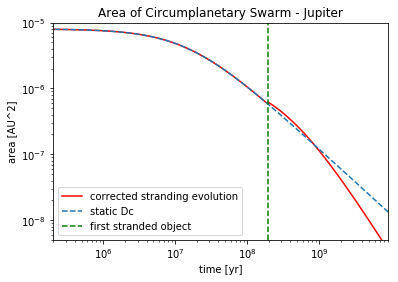

In [11]:
plt.loglog(times/year, area_correct, 'r', label="corrected stranding evolution")
plt.loglog(times/year, area_no_correct, ls='--', label="static Dc")
plt.axvline(jupiter_correct.tnleft/year, color='g', ls='--', label="first stranded object")
plt.xlabel("time [yr]")
plt.ylabel("area [AU^2]")
plt.title("Area of Circumplanetary Swarm - Jupiter")
plt.legend()
plt.xlim([2e5, 9e9])
plt.ylim([5e-9, 1e-5])
plt.show()

## Number Density Plot

Since it is possible to compute the number of objects in the swarm at any time with our code, an other possible plot that can be made is a size-distribution plot for logarithmic spaced times. 

In [8]:
jupiter_num = swarms.CollSwarm(star=star, planet=planet, M0=M0, Dt=Dt, Dmax=Dmax, eta=eta, Q=0.25, Nstr=Nstr, correction=True, alpha=.12)

In [9]:
drange = linspace(0.1, 250000, 5000)
time_log = logspace(0, 10, 30)
num_distribution = []
Dc_list = []
for i in range(len(time_log)):
    #jupiter_num.tnleft = 0.5e8
    jupiter_num.updateSwarm(time_log[i])
    num = []
    dcc = []
    for j in range(len(drange)):
        dcc.append(jupiter_num.swarm.Dc)
        num.append(jupiter_num.computen(drange[j]))
    num_distribution.append(num)
    Dc_list.append(dcc)
    

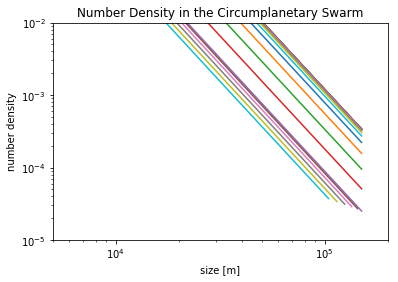

In [10]:
drange = array(drange)
for i in range(len(num_distribution)):
    num_dist = []
    prev_drange = []
    for j in range(len(num_distribution[i])):
        #print("drange = ", drange[j])
        #print("Dc = ", Dc_list[j])
        if drange[j] < Dc_list[i][j]:
            prev_drange.append(drange[j])
            num_dist.append(num_distribution[i][j])
    plt.loglog(prev_drange, num_dist)
#plt.loglog(Dc_list)
#print(Dc_list)
plt.xlim([5000, 200000])
plt.ylim([1e-5, 1e-2])
plt.xlabel("size [m]")
plt.ylabel("number density")
plt.title("Number Density in the Circumplanetary Swarm")
plt.show()

# Observable Quantities

## Flux Computations

We now demonstrate the important computations of thermal radiation flux as well as scattering flux produced by both the planet and the circumplanetary swarm. These values are critical, since they are the observable variables. The distance from the solar system, d_pl, used is 10 pc. We take a Jupiter mass planet orbiting an A5 main-sequence star.  

In [11]:
M0 = 10 * 7.34767309e22; Dt = 100.; Dmax = 250000.; L_s = 20 * 3.828e26;
M_s = 1.86 * 1.989e30; M_pl = 1.89587112e27; a_pl = 7.48e12
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = 3.086e17
Year = 3.154e7 #seconds
Jy = 1e-26

jupiter5 = swarms.CollSwarm(star=star, planet=planet, M0=M0, Dt=Dt, Dmax=Dmax, eta=eta, Q=0.25, Nstr=Nstr, correction=True, alpha=.12)

jupiter5.updateSwarm(1e7*Year) # Update the swarm to 4.5e9 years. 

waverange = logspace(-7, -3, 200)

g = 1.
FscatSwarm = jupiter5.Fscat(waverange, g)/Jy
FthermalSwarm = jupiter5.Fthermal(waverange)/Jy
FthermalPlanet = planet.Fthermal(waverange)/Jy
FscatPlanet = planet.Fscat(waverange, g)/Jy

C:\Users\loloynage\Documents\CE-Irregular-Satellites\K11\swarms.py:209: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(H*(C/lamb)/(K_B*T)) - 1)


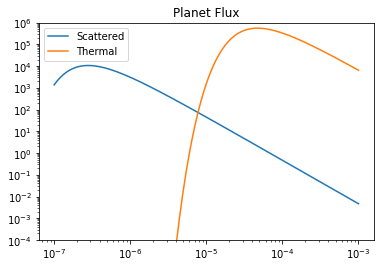

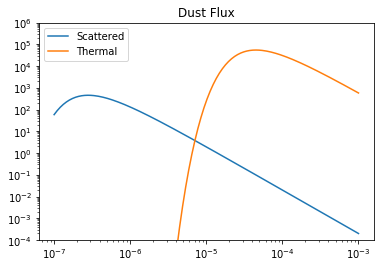

In [12]:
plt.figure(3)
plt.title('Planet Flux')
plt.loglog(waverange, FscatPlanet, label="Scattered")
plt.loglog(waverange, FthermalPlanet, label="Thermal")
plt.ylim([10e-5, 10e5])
plt.legend()
plt.show()

plt.figure(4)
plt.title('Dust Flux')
plt.loglog(waverange, FscatSwarm, label="Scattered")
plt.loglog(waverange, FthermalSwarm, label="Thermal")
plt.ylim([10e-5, 10e5])
plt.legend()
plt.show()

# Evolution of Debris Population

In [13]:
M0 = 0.001 * 7.3477e22; Dt = 100.; Dmax = 150000.; L_s = 3.828e26;
M_s = 1.989e30; M_pl = 1.89587112e27; a_pl = 7.7792e11
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = a_pl

jupiter6 = swarms.CollSwarm(star=star, planet=planet, M0=M0, Dt=Dt, Dmax=Dmax, eta=eta, Q=0.25, Nstr=Nstr, correction=True, alpha=.12)

drange = linspace(0.01, 1.5e5, 2500)
drange_Dc_tot = []
time_log = logspace(6, 10, 10)
total_amount = []


for i in range(len(time_log)):
    jupiter6.updateSwarm(time_log[i])
    num = []
    drange_Dc = []
    for d in drange:#j in range(len(drange)):
        Xc_val = jupiter6.computeXc()
        Mt = jupiter6.swarm.DMtot(jupiter6.Rcc0, time_log[i], jupiter6.tnleft, Xc_val, jupiter6.M_init, jupiter6.correction)
        jupiter6.swarm.M0 = Mt
        num.append(jupiter6.computeNtot(dlow=d)) #Make dhigh explicit
        drange_Dc.append(d)
    drange_Dc_tot.append(drange_Dc)
    total_amount.append(num)

In [14]:
print(time_log)

[1.00000000e+06 2.78255940e+06 7.74263683e+06 2.15443469e+07
 5.99484250e+07 1.66810054e+08 4.64158883e+08 1.29154967e+09
 3.59381366e+09 1.00000000e+10]


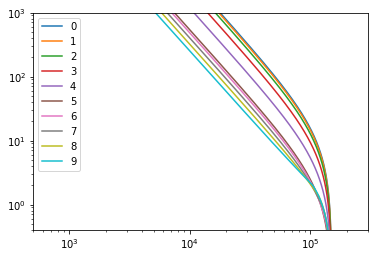

In [15]:
for i in range(len(total_amount)):
    plt.loglog(drange_Dc_tot[i], total_amount[i], label=i)

plt.legend()
plt.ylim([4e-1, 1e3])
plt.xlim([5e2, 3e5])
plt.show()

In [ ]:
# M0 = 10 * 7.34767309e22; Dt = 100.; Dmax = 250000.; L_s = 20 * 3.828e26;
# M_s = 1.86 * 1.989e30; M_pl = 1.89587112e27;
# R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = 3.086e17

# Fth_planet = []; Fth_swarm = []; Fs_planet = []; Fs_swarm = []; 
# a_pl = linspace(0, 10 * 1.496e11, 100 * 1.496e11, 400)
# for i in range(len(a_pl)):
#     jupiter5 = CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl[i], R_pl, eta, Nstr, d_pl, correction=True, alpha=1.2)
#     jupiter5.updateSwarm(1e7) # Update the swarm to 4.5e9 years. 

#     waverange = logspace(-7, -3, 200)
#     Fth_planet = jupiter5.computeFth(waverange, planet=True)/1e-26
#     Fth_swarm = jupiter5.computeFth(waverange, swarm=True)/1e-26
#     Fs_planet = jupiter5.computeFs(waverange, 1., 0.52, planet=True)/1e-26
#     Fs_swarm = jupiter5.computeFs(waverange, 0.32, 0.08, swarm=True)/1e-26